In [ ]:
# use kernel [conda env:ml]
import os
import csv
import _csv
import psutil
import multiprocessing as mp
from typing import TextIO, Union, List

import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
import pyproj
from collections import Counter
import time
import itertools
from collections import Counter

#from aggregator_multi import create_graph
# from .projection_data import projection_data_class
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import statsmodels.api as sm #for linear regression


## Step 1: Load road network from OSM and preprocess
Preprocessing is done by removing edges in the network that we don't need, like sidewalks. This is done with the thin_edges fuction written by Yvonne. 

In [ ]:
def thin_edges(edges, keep_types=None):
    # removes edges from specific types, useful when we only want to use primary roads and no residential or tertiary
    # roads.
    # see https://wiki.openstreetmap.org/wiki/Map_features#Highway for a list of values.
    # some EDA has lead us to the default values. In our application it more important not to remove too many types,
    # as long as the largest batches of unnecessary edges are removed

    # all from the wiki that have a "way" element icon
    all_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "residential",
                 "motorway_link", "trunk_link", "primary_link", "secondary_link", "tertiary_link",
                 "living_street", "service", "pedestrian", "track", "bus_guideway", "escape", "raceway", "road",
                 "busway", "footway", "bridleway", "steps", "corridor", "path", "cycleway", "elevator",
                 "emergency_bay", "platform", "User Defined"]

    if keep_types is None:
        # default value
        keep_types = ["motorway", "trunk", "primary","motorway_link", "trunk_link", "primary_link", "escape"]

    remove_types = [x for x in all_types if x not in keep_types]
    print("Removed types: " + str(remove_types))

    len_1 = len(list(edges["highway"]))

    for rt in remove_types:
        edges.drop(edges.index[edges["highway"] == rt], inplace=True)

    print("Edges have been thinned. Only " + str(len(list(edges["highway"])))
          + " edges remain from original " + str(len_1))

    return edges

##### Loading data, setting crs and thinning edges

In [ ]:
gdf = ox.geocode_to_gdf("Netherlands") # previously this function was gdf_from_places

# get a graph of the union of their boundaries, then extract nodes as geodataframe
G = ox.graph_from_polygon(gdf.unary_union, network_type='drive')

crs_rds = pyproj.crs.CRS("EPSG:28992")
crs_to = crs_rds

In [ ]:
#add edge bearings for later
G = ox.add_edge_bearings(G) 

In [ ]:
# convert graph to rds
Ugraph = ox.project_graph(G, to_crs=crs_to)

In [ ]:
# thin edges and put nodes and thinned edges together in a graph object 
nodes, edges = ox.graph_to_gdfs(Ugraph)
edges = thin_edges(edges)
Ngraph = ox.graph_from_gdfs(nodes, edges)

In [ ]:
#save file 
#ox.io.save_graph_geopackage(Ngraph, filepath="Ngraph_undirected.gpkg", encoding='utf-8', directed=False)
#ox.io.save_graph_geopackage(Ngraph, filepath="Ngraph_directed.gpkg", encoding='utf-8', directed=True)

In [ ]:
#Ngraph = gpd.read_file("Ngraph_directed.gpkg") #didn't work once I tried getting nearest edges

## Step 2: Load Sensor data and assign each sensor to nearest edge
The latter is done with the nearest_edges function from the osmnx package. This also returns the distance to the nearest edge (unit = 100km) if you don't change anything in the sensor's location. 
<br> This is because the Coordinate Reference System (CRS) is 4326, which is the typical longitude/latitude, and not that exact when you project onto a 2D map and want distances in meters. 
<br> To get more exact distances in meters, we change the CRS to EPSG:28992, which is optimal for the Netherlands.

In [ ]:
nlmap_classified_df = pd.read_csv("nlmap_classified_df.csv")

nlmap_classified_gdf = gpd.GeoDataFrame(
    nlmap_classified_df, geometry=gpd.points_from_xy(nlmap_classified_df.longitude, nlmap_classified_df.latitude))

nlmap_classified_gdf.crs = "EPSG:4326"
nlmap_classified_gdf = nlmap_classified_gdf.to_crs("EPSG:28992")

The nearest_edges function returns a warning message that does not seem to be a problem, but is not fully understood yet. 

In [ ]:
all_used_edges = ox.distance.nearest_edges(Ngraph, nlmap_classified_gdf.geometry.x, nlmap_classified_gdf.geometry.y, interpolate=None, return_dist=True)

## Step 3: Put results into a comprehensible dataframe

In [ ]:
all_used_edges_df = pd.DataFrame(all_used_edges)
all_used_edges_df = all_used_edges_df.transpose() #to have two columns in total instead of 1 column per sensor
all_used_edges_df.columns = ["edges", "distance"] 
all_used_edges_df["location_id"] = nlmap_classified_df["location_id"].tolist() #add location_id to each edge-distance
all_used_edges_df["PV_NAAM"] = nlmap_classified_df["PV_NAAM"].tolist()
all_used_edges_df[['node_from', 'node_to', 'zero']] = pd.DataFrame(all_used_edges_df['edges'].tolist(), index=all_used_edges_df.index)
all_used_edges_df.drop('zero', inplace = True, axis = 1)
all_used_edges_df

#### (Save as CSV), uncomment as desired

In [ ]:
#all_used_edges_df.to_csv('edges_and_sensors.csv', index=False) 

In [ ]:
#all_used_edges_df = pd.read_csv("edges_and_sensors.csv")

## Step 4: Assign average sum of workdays to edge-sensor
Only including Tuesdays, Wednesdays and Thursdays, only including month of May, using sample of all observations

##### Load intensities and remove weekdays that are not needed

In [ ]:
entire_rushhour = pd.read_csv("entire_rushhour_shortssummed_datetime.csv")
entire_rushhour = entire_rushhour.loc[entire_rushhour["month"] == 5]
entire_rushhour["time"] = pd.to_datetime(entire_rushhour['time'], format='%Y-%m-%d %H:%M:%S')
entire_rushhour["dayofweek"] = entire_rushhour.time.dt.dayofweek
ent_tu_we_th = entire_rushhour[entire_rushhour["dayofweek"].isin([1,2,3])]

First sum over each day, then average over all days

In [ ]:
ent_tu_we_th_grouped = ent_tu_we_th[["location_id", "date", "value"]]

#first sum up for each day
ent_tu_we_th_grouped = ent_tu_we_th_grouped.groupby(["location_id", "date"], as_index = False).sum()

#then get average sum of working days
ent_tu_we_th_grouped = ent_tu_we_th_grouped.groupby(["location_id"], as_index = False).mean()


Merge with all_used_edges_df and rename  value to "obs" for observed counts

In [ ]:
edges_intensities = all_used_edges_df.merge(ent_tu_we_th_grouped, on = "location_id", how = "outer")
edges_intensities = edges_intensities.rename(columns = {"value": "obs"})

#### Add longitude and latitude from meta data

In [ ]:
meta = pd.read_csv("meta211121.csv")
meta = meta.rename(columns = {"dgl_loc": "location_id"})
meta = meta[["location_id", "coordinates"]]

In [ ]:
edges_intensities = edges_intensities.merge(meta, on = "location_id", how = "left")

#### (Save as CSV), uncomment as desired
#### If you do not have access to CBS, you can load edges_intensities from the repository at this step to continue

In [ ]:
#edges_intensities.to_csv('edges_intensities.csv', index=False) 

In [ ]:
#edges_intensities = pd.read_csv('edges_intensities.csv')

Remove rows with NA's (necessary for visualisation) and rows with 0-counts, which are malfunctioning sensors

In [ ]:
edges_intensities = edges_intensities.dropna(subset=['obs', 'edges'])
edges_intensities = edges_intensities.loc[edges_intensities.obs > 0] 

## Step 5: Correct false directions
The longitude and latitude in the metadata do not refer exactly to the point of measurement (i.e. the lane on which cars are counted), but to a device placed next to the road. This device might collect the measurements of multiple sensors that are placed on lanes that go in different directions (which are considered seperate roads). We use the "meetricht" variable from the meta-data that gives the bearing of the road at the point of measurement and compare it to the bearing of the OSM edge. If the meetricht and the bearing are in opposite directions, we swap the node_from and node_to.

First extract direction from metadata

In [ ]:
meta = pd.read_csv("meta211121.csv")
meta_dir = meta[["meetricht", "dgl_loc"]]
meta_dir = meta_dir.rename(columns = {"dgl_loc": "location_id"})
meta_dir

The metadata contains the meetricht variable, which is missing for around half the sensors in 2019. NDW sent me a shapefile containing another meetricht variable. The file can be requested at the NDW servicedesk (https://www.ndw.nu/contact). This one only contains ~2000 of the sensors that we look at for 2019. Most of the times, when the meetricht variable is missing in the metadata, it is observed in the shapefile. For cases where both are observed, they are almost the same in the vast majority (mean difference of -1). I therefore decided to merge those two to be able to keep more sensors in the dataset. 
<br> I refer to the meta data meetricht as "oldmeetricht" and to the shapefile meetricht as "meetricht"

In [ ]:
ndwdir = gpd.read_file("Data/NDW/Shapefile/Telpunten/Telpunten_WGS84.shp")
ndwdir = ndwdir[["dgl_loc", "meetricht"]].rename(columns = {"dgl_loc": "location_id"})

In [ ]:
intensities_ndwdir = edges_intensities.merge(ndwdir, on='location_id', how = "left")
intensities_ndwdir.meetricht.isna().sum() #check how many are missing

In [ ]:
intensities_ndwdir2 = intensities_ndwdir.loc[intensities_ndwdir.edges.notna()] #remove sensors that were not used in our 2019 dataset

meta_dir2 = meta_dir.rename(columns = {"meetricht": "oldmeetricht"}) #to be able to distinguish shapefile meetricht from metadata meetricht

allmeet = meta_dir2.merge(intensities_ndwdir2, on = "location_id", how = "outer")

allmeet = allmeet.loc[allmeet.edges.notna()]
allmeet

In [ ]:
allmeet["meetdiff"] = allmeet.oldmeetricht - allmeet.meetricht
allmeet.meetdiff.hist(bins = 100)
plt.title('Difference between oldmeetricht and meetricht')

In [ ]:
#new with correct crs
allmeet.meetdiff.describe()

In most cases, the difference between the meta meetricht and the shapefile meetricht is 0. I remove cases where the difference is larger than 5 and assume that a difference of less than 5 can be ignored. 

In [ ]:
allmeet = allmeet.loc[ ((allmeet.meetdiff.isna()) | (abs(allmeet.meetdiff) < 5)) & (allmeet.meetricht.notna() | allmeet.oldmeetricht.notna()) ] #cases were at least one of the two was observed and the differnce was not large
allmeet #4771 rows left

Finally, we have to create a new column for the direction. I decided to favor the oldmeetricht for cases where both are observed. In other cases, only the observed one is kept. This assumes that in missing meetricht values in the metadata, the meetricht in the shapefile is the correct one and vice versa. We name this new column meetricht and name the other two columns accordingly to their origin. 

In [ ]:
allmeet["finalmeetricht"] = np.where(allmeet.oldmeetricht.isna(), allmeet.meetricht, allmeet.oldmeetricht)
allmeet = allmeet.rename(columns = {"oldmeetricht": "meta_meetricht", "meetricht": "ndw_meetricht", "finalmeetricht": "meetricht"})

In [ ]:
#old chunk, this is how I extracted the direction before using the shapefile
#intensities_dir = edges_intensities.merge(meta_dir, on='location_id', how = "left")

#intensities_dir = intensities_dir.dropna() #not all sensors have a meetricht-variable

In [ ]:
intensities_dir #3516 rows

### Get the bearing of each edge

### Visualization of the problem

In [ ]:
def add_features_to_edge(df, edges, features = ["added_feature"], node_from = "node_from", node_to = "node_to", indexerror = np.nan):

    # Code is a simplified and generalized version of Yvonne Gootzen's visualize_intensities function
    edge_idx_0 = [idx[0] for idx, _ in edges.iterrows()]
    edge_idx_1 = [idx[1] for idx, _ in edges.iterrows()]
    
    n_features = len(features)
    features_list = [[] for _ in range(n_features)]
    for nf, nt in zip(edge_idx_0, edge_idx_1):
        for n in range(n_features): #for each feature
    
            try:
                # search in intensities for a have a matching edge
                feat = df.loc[(df[node_from] == nf) & (df[node_to] == nt), features[n]].iloc[0]

                features_list[n].append(feat)

            except IndexError:
                features_list[n].append(indexerror)


    for m in range(n_features):
        edges[features[m]] = features_list[m]
    
    return edges

edges2 = add_features_to_edge(allmeet, edges, features = ["meetricht"])

In [ ]:
edges_dirbear = edges2.dropna(subset = ["meetricht"])

In [ ]:
#new, without emergency bay
plt.scatter(edges_dirbear.meetricht, edges_dirbear.bearing, s = 1)
plt.show()
#add a straight line in this plot

In [ ]:
edges_dirbear["diff"] = edges_dirbear["meetricht"] - edges_dirbear["bearing"]

In [ ]:
#new, without emergency bay
edges_dirbear["diff"].hist(bins = 100)
plt.title('Difference between sensor direction and edge bearing ')

Below is code that can do a similar thing as the add_features_to_edges function, but the other way around, where it adds features from edges to the dataframe. This is faster, and can be useful if we do not need the entire edge dataset. I am keeping this here for the next person at CBS working with sensor data.

In [ ]:
#allmeet was intensities_dir

#extract u, v and bearing
edge_bearing_idx_0 = [idx[0] for idx, _ in edges.iterrows()]
edge_bearing_idx_1 = [idx[1] for idx, _ in edges.iterrows()]
edge_bearing_bearing = edges.bearing.tolist()

#create dictionary 
edge_bearing_idx_01 = list(zip(edge_bearing_idx_0, edge_bearing_idx_1))
bearing_dict = dict(zip(edge_bearing_idx_01, edge_bearing_bearing))

#create node_from_to variable in dataframe
allmeet["node_from_to"] = list(zip(allmeet["node_from"], allmeet["node_to"]))

#create bearing variable using dictionary
allmeet["bearing"] = allmeet["node_from_to"].map(bearing_dict)

In [ ]:
#allmeet was intensities_dir
allmeet["direction_differences"] = allmeet.meetricht - allmeet.bearing

In [ ]:
#allmeet was intensities_dir
plt.scatter(allmeet.meetricht, allmeet.bearing, s = 1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
plt.style.use("bmh")
# Plots #
    # Plot scatter
plt.scatter(allmeet.bearing,allmeet.meetricht, s = 1)

#add diagonal line
ax.axline((1, 1), slope=1, color = "grey", ls = "-", linewidth = 1, alpha = 0.9)

# X #
ax.set_xlabel("OSM edge")

# Y #
#ax.set_yticks([])
ax.set_ylabel("Sensor metadata")

# Overall #
#ax.set_title("Sensor bearing against road segment bearing")
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.grid(False)
plt.rcParams['font.family'] = ['serif']
#fig.savefig("figures/edges_bearing.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

In [ ]:
allmeet.distance.describe()

Flip node_from and node_to where the difference is between 90-270

In [ ]:
# store results in new object called "obs" for observed counts
traffic = allmeet
traffic["abs_direction_differences"] = abs(traffic["direction_differences"])
traffic["node_from_flip"] = np.where((traffic["abs_direction_differences"] > 90) & (traffic["abs_direction_differences"] < 270), traffic["node_to"], traffic["node_from"])
traffic["node_to_flip"] = np.where((traffic["abs_direction_differences"] > 90) & (traffic["abs_direction_differences"] < 270), traffic["node_from"], traffic["node_to"])

In [ ]:
traffic = traffic.rename(columns = {"node_from": "node_from_old", "node_to": "node_to_old"})
traffic = traffic.rename(columns = {"node_from_flip": "node_from", "node_to_flip": "node_to"})

In [ ]:
# save as csv
#obs.to_csv('intensities_dir_flipped.csv', index=False) 

In [ ]:
#obs = pd.read_csv("intensities_dir_flipped.csv")

Plot histogram of observed counts

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
plt.style.use("bmh")
# Plots #
    # Plot histogram
traffic["obs"].plot(kind = "hist", density = False, alpha = 0.8, bins = 70) # change density to true, because KDE uses density

# X #
ax.set_xlabel("Counts")

# Y #
#ax.set_yticks([])
    # Relabel the axis as "Frequency"
ax.set_ylabel("Frequency")

# Overall #
ax.set_title("Observed traffic counts")
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.grid(False)
plt.rcParams['font.family'] = ['serif']
#fig.savefig("figures/obs_hist.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

## Step 6: Visualize intensities

The value-variable has a wide spread. For plotting with a colorscale, we need it to be normally distributed. We achive this by applying a cube root transformation:

In [ ]:
traffic["obscb"] = traffic.obs**(1/3)
traffic["obscb"].hist(bins = 100)
plt.title("Distribution of observed traffic count after $\sqrt[3]{.}$-transformation")

#### Add obs and obscb to edges

In [ ]:
edges2 = add_features_to_edge(traffic, edges2, features = ["obs", "obscb"], node_from = "node_from", node_to = "node_to", indexerror = 0)

#### Next, create custom colormap to grey out edges that do not have sensors
The first value on the scale (0) will be grey, rest will range from yellow to blue
(code found on stackoverflow)

In [ ]:
from matplotlib.colors import ListedColormap
def plot_examples(colormaps, lo = 1, hi = 100):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randint(low = lo, high = hi, size = (30,30))
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=lo, vmax=hi)
        fig.colorbar(psm, ax=ax)
    plt.show()
#modify colormap 

In [ ]:
exp_plot.exp_car.describe()

In [ ]:
#create colorscales
# Diverging color scale to see both below and above 1 values, set lowest value to grey colour
# colormap for c
seismic = cm.get_cmap('seismic', 101)
seismic_colors = seismic(np.linspace(0.175, 1, 101))
darkgrey = np.array([0.5, 0.5, 0.5, 0.15]) #the fourth value sets the transparency of the color. This is necessary, because the grey roads would otherwise cover up the colored roads
seismic_colors[:1 :] = darkgrey
seismiccmp = ListedColormap(seismic_colors)

#colormap for c*
#get min and max of cs_plot to cut off top and bottom of scale, multiply by 0.01 to get value between 0 and 1
cs_min = edges_calibrated["cs_plot"].min() * 0.01
cs_max = edges_calibrated["cs_plot"].max() * 0.01

seismic_colors2 = seismic(np.linspace(cs_min+ 0.175, cs_max, 101))
seismic_colors2[:1 :] = darkgrey

seismiccmp2 = ListedColormap(seismic_colors2)

plot_examples([seismiccmp, seismiccmp2])

ec = ox.plot.get_edge_colors_by_attr(graph, attr="intensity", cmap= newcmp)

fig, ax = ox.plot_graph(graph, node_color="w", node_edgecolor="k", node_size=0, edge_color=ec, edge_linewidth=2) #weights does not work for linewidth

plt.show()Assign colors to edges based on intensity and plot graph

In [ ]:
# Create colorbar that has the first value 0 mapped to the color grey (edges with no sensors have "0" for the observed count - these will be grey in the plot)
hot = cm.get_cmap('hot', int(traffic["obscb"].max()))
newcolors = hot(np.linspace(0.1, 1, int(traffic["obscb"].max())))
darkgrey = np.array([0.5, 0.5, 0.5, 0.15]) #the fourth value sets the transparency of the color. This is necessary, because the grey roads would otherwise cover up the colored roads
newcolors[:1 :] = darkgrey

newcmp1 = ListedColormap(newcolors)

plot_examples([hot, newcmp1], lo = traffic["obscb"].min(), hi = traffic["obscb"].max())

In [ ]:
plt.scatter(traffic.obs, traffic.obscb)
plt.title("Transformed vs. untransformed obs (shows what each color represents)")

Now we have to take care of the legend of the plot. This is important, because we want the plot to be informative and also comparable to the same plot for expected counts. Both observed and expected counts are cube root transformed. To have a more gradual change in colors and to get rid of the grey color at the bottom, we create another colormap specifically for the colorbar:

In [ ]:
# for colorbar
hot_cb = cm.get_cmap('hot', 512)
newcolors_cb = hot_cb(np.linspace(0, 1, 512))

newcmp_cb = ListedColormap(newcolors_cb)
plot_examples([newcmp_cb])

The transformed counts in obscb range from 0-25. For the plot, we want to have a legend with tick labels with the backtransformed observed counts at 5, 10, 15, 20 and 25. For example, the observed count at the first tick label is 5^3 = 125 cars. To keep the tick labels short, I use scientific notation, i.e. 125 cars written as $1.3 \times 10^2$ cars.
<br> The position of these tick labels on the legend needs to be given on a scale of 0-1. To get the first position, we can compute 5/obs.obscb.max(). To get the second position, 5/obs.obscb.max() * 2, etc. 

In [ ]:
# Get tick label positions
for i in range(1,6): print((5 / traffic["obscb"].max()) * i)

In [ ]:
graph = ox.graph_from_gdfs(nodes, edges2)
ec = ox.plot.get_edge_colors_by_attr(graph, attr="obscb", cmap= newcmp1)

fig, ax = ox.plot_graph(graph, node_color="w", node_edgecolor="k", node_size=0, edge_color=ec, edge_linewidth=2, show = False) 

# add colorbar
sm = mpl.cm.ScalarMappable(cmap = newcmp_cb)
sm.set_array([])
cb = fig.colorbar(cm.ScalarMappable(cmap = newcmp_cb), ax = ax, location = 'right', shrink = 0.8, ticks = [0.198, 0.396, 0.594,0.792,0.998])
cb.ax.set_yticklabels([r'$1.3 \times 10^2$', r'$1 \times 10^3$', r'$3.4 \times 10^3$', r'$8 \times 10^3$',r'$1.56 \times 10^4$'])
cb.ax.set_ylabel('observed cars', rotation = 90)


#fig.savefig("playgorund/obs_intensities.pdf", format = "pdf", bbox_inches = "tight", pad_inches = 0, dpi = 1000) #bbox_inches and pad_inches ensure that there is no white frame around the plot
plt.show()

## Step 7: Visualize expected counts

If you don't have access to CBS data, you can <b> generate expected counts for each edge on the OSM network. The expected count data resembles a gamma distribution with shape parameter = 1.1 and scale parameter = 3000. Uncomment the lines in the below chunk to create this synthetic data set of expected counts, and comment the line in the following chunk that tries to read the expected counts from CBS.

<AxesSubplot:>

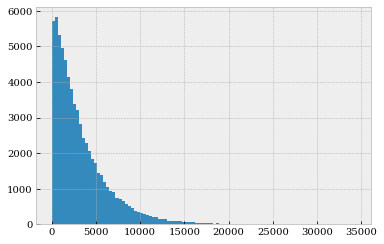

In [240]:
exp_synth = edges2
exp_synth = pd.DataFrame(exp_synth.reset_index())
exp_synth["node_from"] = exp_synth["u"]
exp_synth["node_to"] = exp_synth["v"]
exp_synth = exp_synth[["node_from", "node_to"]]
exp_synth["exp_car"] = np.random.gamma(shape = 1.1, scale = 3000, size =  len(exp_synth))
exp_synth["exp_car"].hist(bins = 100)
#exp = exp_synth

In [ ]:
exp = pd.read_csv('/data2/dacimob/wk_2019_CAR_15_v2.EXPECTED.csv')

There are 12 entries in the data set that do not have a node_from or node_to (they also have extremely high expected counts). I remove these entries, because they are likely errors

In [ ]:
exp = exp.loc[~exp.node_from.isna()]
exp

In [ ]:
exp["node_from_to_new"] = list(zip(exp.node_from, exp.node_to))
len(exp.node_from_to_new.unique()) - len(exp) #no duplicates

In the thesis, I showed a histogram of expected counts, but only for the road segments where we also have observed counts, so that those two histograms can be more comparable. For this, we have to merge the expected counts to the traffic data frame. 

In [ ]:
exp = exp.rename(columns = {"exp_car": "exp"})
traffic = traffic.merge(exp, on = ["node_from", "node_to"], how = "inner")

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
plt.style.use("bmh")
# Plots #
    # Plot histogram
traffic["exp"].plot(kind = "hist", density = False, alpha = 0.8, bins = 70) # change density to true, because KDE uses density

# X #
ax.set_xlabel("Counts")

# Y #
#ax.set_yticks([])
    # Relabel the axis as "Frequency"
ax.set_ylabel("Frequency")

# Overall #
ax.set_title("Expected traffic counts")
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.grid(False)
plt.rcParams['font.family'] = ['serif']
#fig.savefig("figures/exp_hist.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

To get the plot of the road network with expected traffic counts, we need to repeat the steps we did to get the plot for the observed counts. 

In [ ]:
exp["expcb"] = exp.exp**(1/3)
exp["expcb"].hist(bins = 100)
plt.title("Distribution of expected traffic count after $\sqrt[3]{.}$-transformation")

In [ ]:
hot2 = cm.get_cmap('hot', int(exp.expcb.max()))
newcolors2 = hot2(np.linspace(0, 1, int(exp.expcb.max())))
darkgrey = np.array([0.5, 0.5, 0.5, 0.15]) #the fourth value sets the transparency of the color. This is necessary, because the grey roads would otherwise cover up the colored roads
newcolors2[:1 :] = darkgrey

newcmp2 = ListedColormap(newcolors2)

plot_examples([hot2, newcmp2], lo = exp.expcb.min(), hi = exp.expcb.max())

In [ ]:
plt.scatter(exp.exp, exp.expcb)
plt.title("Transformed vs. untransformed exp (shows what each color represents)")

In [ ]:
# Get tick label positions
for i in range(1,6): print((6 / exp["expcb"].max()) * i)

#### Add exp and expcb to edges

In [ ]:
edges2 = add_features_to_edge(exp, edges2, features = ["exp", "expcb"], node_from = "node_from", node_to = "node_to", indexerror = 0)

In [ ]:
graph = ox.graph_from_gdfs(nodes, edges2)
ec = ox.plot.get_edge_colors_by_attr(graph, attr="expcb", cmap= newcmp2)
fig, ax = ox.plot_graph(graph, node_color="w", node_edgecolor="k", node_size=0, edge_color=ec, edge_linewidth=2, show = False) #weights does not work for linewidth

# add colorbar
sm = mpl.cm.ScalarMappable(cmap = newcmp_cb)
sm.set_array([])
cb = fig.colorbar(cm.ScalarMappable(cmap = newcmp_cb), ax = ax, location = 'right', shrink = 0.8, ticks = [0.149, 0.298, 0.447,0.596,0.745,0.894])
cb.ax.set_yticklabels([r'$1.3 \times 10^2$', r'$1 \times 10^3$', r'$3.4 \times 10^3$', r'$8 \times 10^3$',r'$1.56 \times 10^4$', r'$2.7 \times 10^4$'])
cb.ax.set_ylabel('expected cars', rotation = 90)

#fig.savefig("playgorund/exp_intensities.pdf", bbox_inches = "tight", pad_inches = 0, dpi=1000, format = "pdf")
plt.show()

Finally, I also looked at the distribution of the difference between observed and expected counts.

In [ ]:
traffic["obsexpdiff"] = traffic["exp"] - traffic["obs"]

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
plt.style.use("bmh")
# Plots #
    # Plot histogram
traffic["obsexpdiff"].plot(kind = "hist", density = False, alpha = 0.8, bins = 50) # change density to true, because KDE uses density

# X #
ax.set_xlabel("Difference")

# Y #
#ax.set_yticks([])
    # Relabel the axis as "Frequency"
ax.set_ylabel("Frequency")

# Overall #
ax.set_title("Difference between observed and expected road segment count")
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.grid(False)
plt.rcParams['font.family'] = ['serif']
#fig.savefig("figures/obs_exp_diff.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

In [ ]:
edges2.to_csv("Data/output/edges_with_counts.csv", index = False)
traffic.to_csv("Data/output/traffic.csv", index = False)

In [ ]:
# store objects in environment so that you can load them into the notebook inspect_model_c.ipynb
%store Ngraph
%store edges2
%store nodes
%store traffic

# Cluster analysis
I did this before I realised that exp should be an explanatory variable. This code is not up to date, however, I am leaving this in here as inspiration for the next person that might have more variables and wants to perform a clustering analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### without ratio in PCA

In [ ]:
modeldat = edges3[['cuberoot_ratio', 'popdens', 
       'is_bridge', 'maxmaxspeed', 'maxlanes']]
modeldat = modeldat.dropna()
crratio = modeldat["cuberoot_ratio"]
modeldat = modeldat.drop(columns = "cuberoot_ratio")
scaler = StandardScaler()
scaled_modeldat = scaler.fit_transform(modeldat)

#### 2d/ 2 components

In [ ]:
pca = PCA(n_components = 2)
components = pca.fit_transform(scaled_modeldat)

plt.scatter(components[:,0], components[:,1], c = crratio)
plt.colorbar()

#### 3d/ 3 components

In [ ]:
pca = PCA(n_components = 3)
components = pca.fit_transform(scaled_modeldat)

ax = plt.axes(projection='3d')
p = ax.scatter3D(components[:,0], components[:,1], components[:,2], c = crratio)
fig.colorbar(p, ax = ax)

### With ratio in PCA

In [ ]:
modeldat = edges3[['cuberoot_ratio', 'popdens', 
       'is_bridge', 'maxmaxspeed', 'maxlanes']]
modeldat = modeldat.dropna()
crratio = modeldat["cuberoot_ratio"]
#modeldat = modeldat.drop(columns = "cuberoot_ratio")
scaler = StandardScaler()
scaled_modeldat = scaler.fit_transform(modeldat)

#### 2d/ 2 components

In [ ]:
pca = PCA(n_components = 2)
components = pca.fit_transform(scaled_modeldat)

plt.scatter(components[:,0], components[:,1], c = crratio)
plt.colorbar()

#### 3d/ 3 components

In [ ]:
pca = PCA(n_components = 3)
components = pca.fit_transform(scaled_modeldat)

ax = plt.axes(projection='3d')
p = ax.scatter3D(components[:,0], components[:,1], components[:,2], c = crratio)
fig.colorbar(p, ax = ax)
#ax.show()